<a href="https://colab.research.google.com/github/paulmyr/jaxley/blob/main/notebooks/jaxley_test_adex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use custom jaxley build<br>
-> fork in github.com/paulmyr/jaxley.git

In [1]:
!git clone https://github.com/paulmyr/jaxley.git
!pip install tridiax

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/content/jaxley')

import jaxley as jx


fatal: destination path 'jaxley' already exists and is not an empty directory.


Parameters from the paper:

In [2]:

NAUD_PARAMETERS = {
    'tonic': {
        'C_m': 200,      # pF - Membrane capacitance
        'g_L': 10,       # nS - Leak conductance
        'E_L': -70,      # mV - Leak reversal potential
        'v_T': -50,      # mV - Spike threshold
        'delta_T': 2,    # mV - Spike slope factor
        'v_reset': -58,  # mV - Reset potential (NOT -70!)
        'v_threshold': 0,  # mV - Detection threshold for spike cutoff
        'tau_w': 30,     # ms - Adaptation time constant
        'a': 2,          # nS - Subthreshold adaptation
        'b': 0,          # pA - Spike-triggered adaptation (none for tonic)
        'I': 0.5,        # nA - Injected Current
    },
    'adaptation': {
        'C_m': 200,      # pF
        'g_L': 12,       # nS - Slightly higher leak
        'E_L': -70,      # mV
        'v_T': -50,      # mV
        'delta_T': 2,    # mV
        'v_reset': -58,  # mV
        'v_threshold': 0,  # mV
        'tau_w': 300,    # ms - 10x slower adaptation!
        'a': 2,          # nS
        'b': 60,         # pA - Strong spike-triggered adaptation
        'I': 0.5,        # nA - Injected Current
    },
    'original': {
        'C_m': 281,        # pF
        'g_L': 30,         # nS - Slightly higher leak
        'E_L': -70.6,      # mV
        'v_T': -50.4,      # mV
        'delta_T': 2,      # mV
        'v_reset': -70.6,  # mV
        'v_threshold': 20, # mV
        'tau_w': 144,      # ms - 10x slower adaptation!
        'a': 4,            # nS
        'b': 80.5,         # pA - Strong spike-triggered adaptation
        'I': 2.5,          # nA - Injected Current
    },
}


In [3]:
def geometry_agnostic_to_jaxley(
    C_m_pF: float,
    g_L_nS: float,
    a_nS: float,
    b_pA: float,
    I_ext_nA: float
    #cell_radius_um: float,
    #cell_length_um: float
) -> dict:
    """
    Convert Naud et al. geometry-agnostic parameters to Jaxley density units.

    - Naud specifies C_m = 200 pF (total capacitance)
    - Jaxley uses C_m = 1.0 μF/cm² (specific capacitance, standard value)
    - We size the cell so that: 1.0 μF/cm² × Area = 200 pF

    Conductances and currents ARE converted to density units by dividing by area.

    Parameters:
        C_m_pF: Membrane capacitance (pF) - used only for verification
        g_L_nS: Leak conductance (nS)
        a_nS: Subthreshold adaptation conductance (nS)
        b_pA: Spike-triggered adaptation current (pA)
        I_ext_nA: External current injection (nA)
        cell_radius_um: Cell radius (μm)
        cell_length_um: Cell length (μm)

    Returns:
        Dictionary with parameters in Jaxley density units
    """
    # Calculate surface area in cm²

    # Use Jaxley's standard specific capacitance
    C_m_uF_cm2 = 1.0  # μF/cm² (standard membrane capacitance)

    area_cm2 = C_m_pF / 1e6 / C_m_uF_cm2
    print(f"a = {area_cm2}cm²")
    radius_cm = jnp.sqrt(area_cm2 / (2 * jnp.pi))
    length_cm = radius_cm
    # area_cm2 = 2 * jnp.pi * radius_cm * length_cm

    # Convert conductances and currents to density units
    g_L_S_cm2 = (g_L_nS * 1e-9) / area_cm2         # nS to S/cm²
    a_S_cm2 = (a_nS * 1e-9) / area_cm2             # nS to S/cm²
    b_mA_cm2 = (b_pA * 1e-12) / area_cm2           # pA to mA/cm²
    I_ext_nA_cm2 = (I_ext_nA)  / area_cm2          # nA to mA/cm²


    # Calculate total capacitance for verification
    total_capacitance_pF = C_m_uF_cm2 * area_cm2 * 1e6

    return {
        'capacitance': C_m_uF_cm2,
        'g_L': g_L_S_cm2,
        'a': a_S_cm2,
        'b': b_mA_cm2,
        'I_ext': I_ext_nA_cm2,
        'area_cm2': area_cm2,
        'area_um2': area_cm2 * 1e8,
        'radius_um': radius_cm * 1e4,
        'length_um': length_cm * 1e4,
        'total_C_pF': total_capacitance_pF,
        'target_C_pF': C_m_pF,
    }

def convert_params(naud_parameters: dict):
    C_m, g_L, E_L, v_T, delta_T, v_reset, v_threshold, tau_w, a, b, I_ext = naud_parameters.values()

    jaxley_params = geometry_agnostic_to_jaxley(
        C_m,
        g_L,
        a,
        b,
        I_ext
    )
    jaxley_params['E_L'] = E_L
    jaxley_params['v_T'] = v_T
    jaxley_params['delta_T'] = delta_T
    jaxley_params['v_reset'] = v_reset
    jaxley_params['v_threshold'] = v_threshold
    jaxley_params['tau_w'] = tau_w

    print(jaxley_params)
    return jaxley_params


/content/jaxley/jaxley/channels/non_capacitive/adex.py:85: UserWarning: The AdEx channel does not support surrogate gradients. Its gradient will be zero after every spike. Use AdExSurrogate for differentiable spiking.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


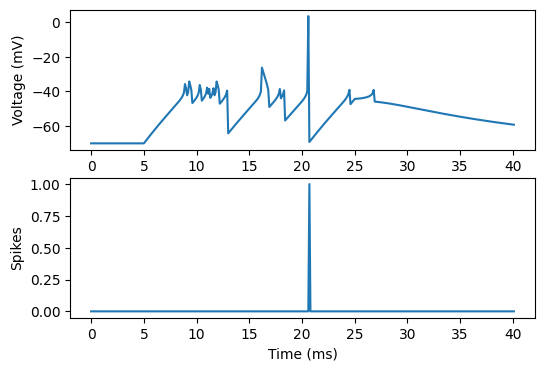

In [4]:
# Leaky integrate-and-fire neurons.
from jaxley.channels import AdEx

cell = jx.Cell()
cell.insert(AdEx())
cell.record("v")
cell.record("AdEx_spikes")

dt = 0.1
t_max = 40.0

cell.stimulate(jx.step_current(5.0, 20.0, 0.005, dt, t_max))
v = jx.integrate(cell, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
_ = ax[0].plot(time_vec, v[0])
_ = ax[1].plot(time_vec, v[1])
_ = ax[0].set_ylabel("Voltage (mV)")
_ = ax[1].set_ylabel("Spikes")
_ = ax[1].set_xlabel("Time (ms)")

/content/jaxley/jaxley/channels/non_capacitive/adex.py:85: UserWarning: The AdEx channel does not support surrogate gradients. Its gradient will be zero after every spike. Use AdExSurrogate for differentiable spiking.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


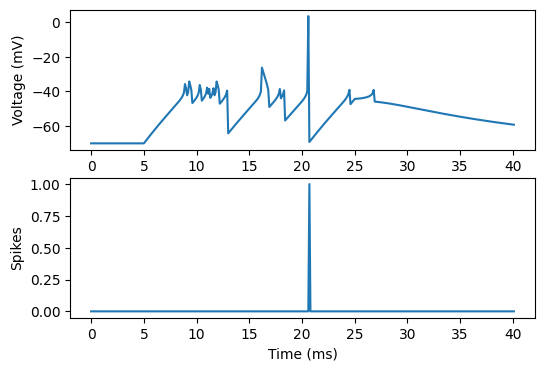

In [5]:
cmprtmt = jx.Compartment()
cmprtmt.insert(AdEx())
cmprtmt.record("v")
cmprtmt.record("AdEx_spikes")

dt = 0.1
t_max = 40.0

cmprtmt.stimulate(jx.step_current(5.0, 20.0, 0.005, dt, t_max))
v = jx.integrate(cmprtmt, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
_ = ax[0].plot(time_vec, v[0])
_ = ax[1].plot(time_vec, v[1])
_ = ax[0].set_ylabel("Voltage (mV)")
_ = ax[1].set_ylabel("Spikes")
_ = ax[1].set_xlabel("Time (ms)")

/content/jaxley/jaxley/channels/non_capacitive/adex.py:85: UserWarning: The AdEx channel does not support surrogate gradients. Its gradient will be zero after every spike. Use AdExSurrogate for differentiable spiking.
  warn(


a = 0.000281cm²
{'capacitance': 1.0, 'g_L': 0.00010676156583629895, 'a': 1.4234875444839859e-05, 'b': 2.864768683274021e-07, 'I_ext': 8896.79715302491, 'area_cm2': 0.000281, 'area_um2': 28100.0, 'radius_um': Array(66.87491, dtype=float32, weak_type=True), 'length_um': Array(66.87491, dtype=float32, weak_type=True), 'total_C_pF': 281.0, 'target_C_pF': 281, 'E_L': -70.6, 'v_T': -50.4, 'delta_T': 2, 'v_reset': -70.6, 'v_threshold': 20, 'tau_w': 144}
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


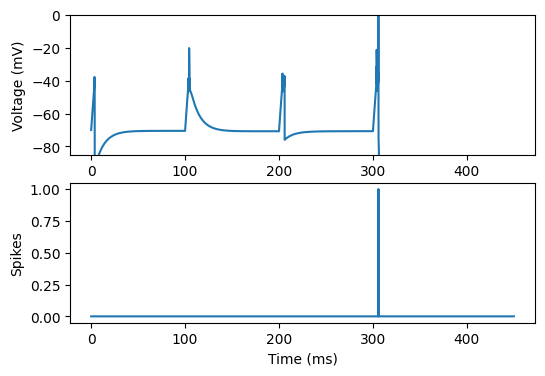

In [7]:
cmprtmt = jx.Compartment()
cmprtmt.insert(AdEx())

JAXLEY_PARAMETERS = convert_params(NAUD_PARAMETERS['original'])

cmprtmt.set('capacitance', JAXLEY_PARAMETERS['capacitance'])
cmprtmt.set('radius', JAXLEY_PARAMETERS['radius_um'])
cmprtmt.set('length', JAXLEY_PARAMETERS['length_um'])

cmprtmt.set('AdEx_g_L', JAXLEY_PARAMETERS['g_L'])
cmprtmt.set('AdEx_E_L', JAXLEY_PARAMETERS['E_L'])
cmprtmt.set('AdEx_v_T', JAXLEY_PARAMETERS['v_T'])
cmprtmt.set('AdEx_delta_T', JAXLEY_PARAMETERS['delta_T'])
cmprtmt.set('AdEx_v_reset', JAXLEY_PARAMETERS['v_reset'])
cmprtmt.set('AdEx_v_threshold', JAXLEY_PARAMETERS['v_threshold'])
cmprtmt.set('AdEx_tau_w', JAXLEY_PARAMETERS['tau_w'])
cmprtmt.set('AdEx_a', JAXLEY_PARAMETERS['a'])
cmprtmt.set('AdEx_b', JAXLEY_PARAMETERS['b'])

cmprtmt.record("v")
cmprtmt.record("AdEx_spikes")

dt = 0.05
t_max = 450

I_ext = JAXLEY_PARAMETERS['I_ext']
I_ext = 2.5

cmprtmt.stimulate(jx.step_current(0, 5, I_ext, dt, t_max))
cmprtmt.stimulate(jx.step_current(100, 5, I_ext, dt, t_max))
cmprtmt.stimulate(jx.step_current(200, 5, I_ext, dt, t_max))
cmprtmt.stimulate(jx.step_current(300, 5, I_ext, dt, t_max))
cmprtmt.stimulate(jx.step_current(400, 5, I_ext, dt, t_max))
v = jx.integrate(cmprtmt, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
_ = ax[0].plot(time_vec, v[0])
_ = ax[1].plot(time_vec, v[1])
_ = ax[0].set_ylabel("Voltage (mV)")
_ = ax[0].set_ylim([-85, 0])
_ = ax[1].set_ylabel("Spikes")
_ = ax[1].set_xlabel("Time (ms)")